In [1]:
from immune_functions import *
from matplotlib.backends import backend_pdf as bpdf
import pickle

# Look at cross-reactivity networks

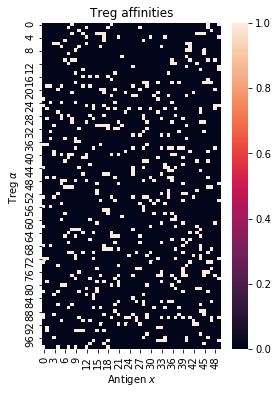

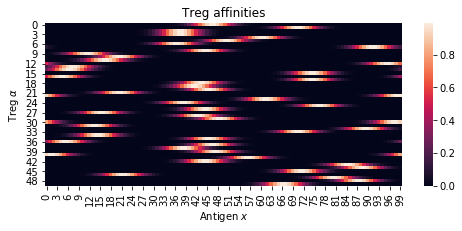

In [11]:
# Parameters
params = {}
params['sampling'] = 'Binary'
params['Num_treg'] = 100
params['Num_tcell'] = 100
params['Num_sites'] = 50
params['pval_cell'] = 0.1
params['pval_treg'] = 0.1
params['c'] = 1
params['sigma_cp'] = 0

# Make affinities and plot
pix, palphax = MakeAffinities(params)
fig,ax=plt.subplots(figsize=(4,6))
sns.heatmap(palphax,ax=ax)
ax.set_title('Treg affinities')
ax.set_xlabel(r'Antigen $x$')
ax.set_ylabel(r'Treg $\alpha$')
pdf = bpdf.PdfPages('../figures/treg_binary.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

params['sampling'] = '1D'
params['Num_sites'] = 100
params['Num_treg'] = 50
params['niche_width'] = 2*params['Num_sites']/params['Num_treg']

# Make affinities and plot
pix, palphax = MakeAffinities(params)
fig,ax=plt.subplots(figsize=(8,3))
sns.heatmap(palphax,ax=ax)
ax.set_title('Treg affinities')
ax.set_xlabel(r'Antigen $x$')
ax.set_ylabel(r'Treg $\alpha$')
pdf = bpdf.PdfPages('../figures/treg_gauss.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Full model

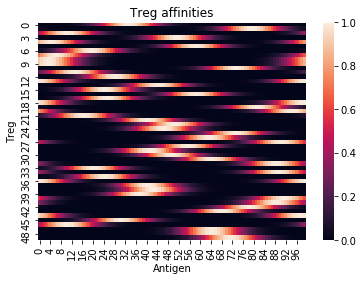

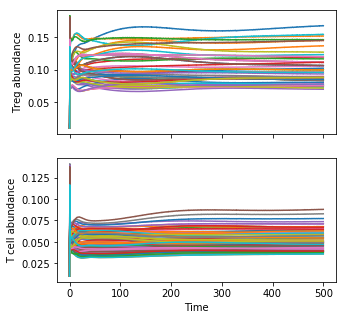

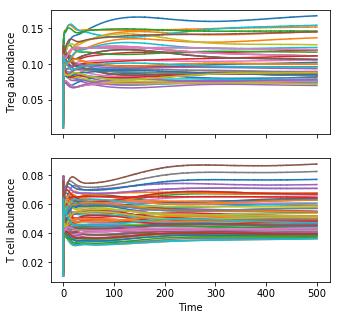

In [2]:
# Parameters
t0 = 0
tf = 500
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 50
params['Num_tcell'] = 100
params['Num_sites'] = 100
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']
y0 = np.ones(params['Num_treg']+params['Num_tcell'])*0.01

# Make affinities and plot
pix, palphax = MakeAffinities(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

#Make antigen concentrations
vx = np.random.rand(params['Num_sites'])

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)

out = solve_ivp(lambda t,y: ddt_simple(t,y,phi_reg_reg,phi_cell_reg,rvals),(t0,tf),y0)
Tcell_approx = out.y[:params['Num_tcell'],:].T
Treg_approx = out.y[params['Num_tcell']:,:].T
t = out.t
fig,ax=plt.subplots(2,sharex=True,figsize=(5,5))
#fig.subplots_adjust(left=0.2)
ax[0].plot(t,Treg_approx)
ax[0].set_ylabel('Treg abundance')
ax[1].plot(t,Tcell_approx)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('T cell abundance')
pdf = bpdf.PdfPages('../figures/dynamics_approx.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

out = solve_ivp(lambda t,y: ddt_full(t,y,pix,palphax,vx),(t0,tf),y0,t_eval=t)
Tcell_exact = out.y[:params['Num_tcell'],:].T
Treg_exact = out.y[params['Num_tcell']:,:].T
t = out.t
fig,ax=plt.subplots(2,sharex=True,figsize=(5,5))
#fig.subplots_adjust(left=0.2)
ax[0].plot(t,Treg_exact)
ax[0].set_ylabel('Treg abundance')
ax[1].plot(t,Tcell_exact)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('T cell abundance')
pdf = bpdf.PdfPages('../figures/dynamics_exact.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

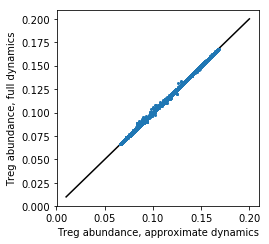

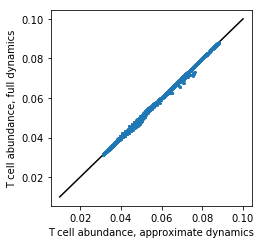

In [4]:
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.2,bottom=0.2)
ax.plot([0.01,0.2],[0.01,0.2],'k')
ax.plot(Treg_approx[10:,].reshape(-1),Treg_exact[10:,].reshape(-1),'o',ms=2)
ax.set_xlabel('Treg abundance, approximate dynamics')
ax.set_ylabel('Treg abundance, full dynamics')
plt.savefig('../figures/treg_compare.png')
plt.show()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.2,bottom=0.2)
ax.plot([0.01,0.1],[0.01,0.1],'k')
ax.plot(Tcell_approx[10:,].reshape(-1),Tcell_exact[10:,].reshape(-1),'o',ms=2)
ax.set_xlabel('T cell abundance, approximate dynamics')
ax.set_ylabel('T cell abundance, full dynamics')
plt.savefig('../figures/tcell_compare.png')
plt.show()

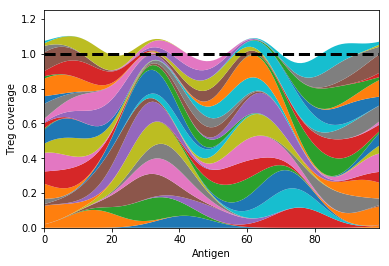

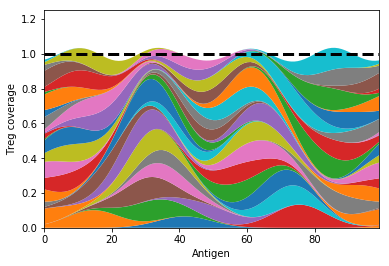

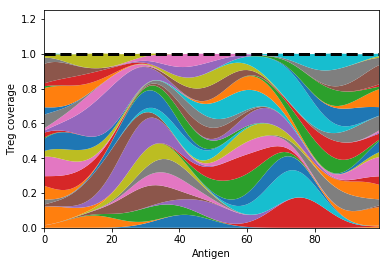

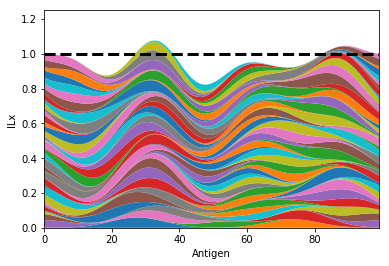

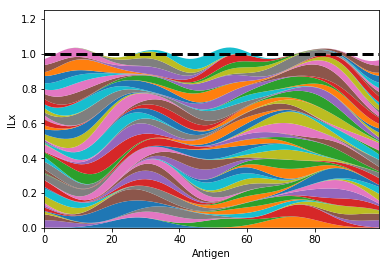

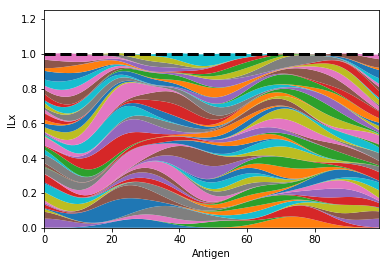

In [27]:
#Plot Treg coverage
times = [8,18,-1]
for time in times:
    coverage = palphax.T*Treg_exact[time]
    fig,ax = plt.subplots()
    ax.stackplot(np.arange(len(vx)),coverage.T)
    ax.plot([0,99],[1,1],'k--',lw=3)
    ax.set_ylim((0,1.25))
    ax.set_xlim((0,99))
    ax.set_xlabel('Antigen')
    ax.set_ylabel('Treg coverage')
    plt.show()
    
#Plot IL coverage
times = [8,18,-1]
for time in times:
    coverage = (pix.T*Tcell_exact[time])/(palphax.T.dot(Treg_exact[time]))
    fig,ax = plt.subplots()
    ax.stackplot(np.arange(len(vx)),coverage.T)
    ax.plot([0,99],[1,1],'k--',lw=3)
    ax.set_ylim((0,1.25))
    ax.set_xlim((0,99))
    ax.set_xlabel('Antigen')
    ax.set_ylabel('ILx')
    plt.show()

# Phase transition

[Landmann and Engel (2018)](https://iopscience.iop.org/article/10.1209/0295-5075/124/18004/pdf) report criteria for the existence of positive solutions $\mathbf{x}$ ($x_i\geq 0$ for all $i$) to a linear system of equations

\begin{align}
A \mathbf{x} = \mathbf{R}
\end{align}

where $A$ is an i.i.d. random matrix of dimension $N \times M$ and the elements of $\mathbf{R}$ are $R_i = 1 + \delta R_i$, where $\delta R_i$ is a Gaussian random variable with mean 0 and variance $r^2/N$. They find a sharp transition in the probability of a solution existing, as a function of the ratio $\alpha = M/N$ and the noise $r^2$. When $r^2 = 0$, the transition takes place at $\alpha_c = 2$. 

We now see that the problem of eliminating sensitivity to $v_x$ takes precisely this form. Setting $\partial g_i/\partial v_x = 0$ gives

\begin{align}
\sum_\alpha p_{\alpha x} \frac{w_\alpha}{\rho} = 1.
\end{align}

When $p_{\alpha x}$ is binary, this is precisely the problem studied by Landmann and Engel, and should have the same phase transition.

It seems to work, with the precision of the shielded phase determined by the number of T cells.

## Binary, i.i.d.

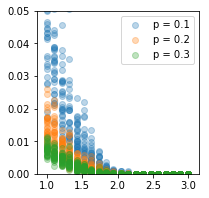

In [11]:
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.15)
sensitivity = pd.read_csv('../data/sensitivity_binary.csv',index_col=0)
for p,data in sensitivity.groupby('p'):
    ax.scatter(data['alpha'].values,data['Qvar'].values,label='p = '+str(p),alpha=0.3)
plt.legend()
ax.set_ylim((0,.05))
pdf = bpdf.PdfPages('../figures/sense_binary.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

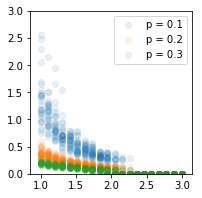

In [25]:
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.15)
sensitivity = pd.read_csv('../data/sensitivity_binary.csv',index_col=0)
for p,data in sensitivity.groupby('p'):
    ax.scatter(data['alpha'].values,data['ILvar'].values,label='p = '+str(p),alpha=0.1)
plt.legend()
ax.set_ylim((0,3))
pdf = bpdf.PdfPages('../figures/sense_binary_IL.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## 1D niche axis

Can also try with the Gaussian matrices. My conjecture is that $\alpha$ corresponds to the inverse fraction of nonzero eigenvalues. It's a crossover, though, with approximately exponential decay.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


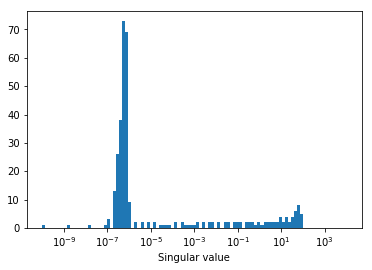

In [12]:
with open('../data/spectra.dat','rb') as f:
    spectrum = pickle.load(f)

k=-10 #index of the run to examine
plt.hist(np.sqrt(np.real(spectrum[k])),bins=np.logspace(-10,4,100))
plt.gca().set_xscale('log')
plt.gca().set_xlabel('Singular value')
plt.show()

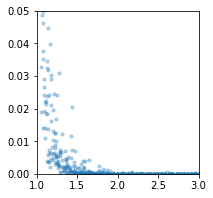

In [13]:
sensitivity = pd.read_csv('../data/sensitivity_1D.csv',index_col=0)
thresh=1e-6
Nreff = []
for item in sensitivity.index:
    Nreff.append((np.sqrt(np.abs(spectrum[item]))>thresh).sum())
    sensitivity.loc[item,'alpha'] = 500/Nreff[-1]
    
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.15)
ax.scatter(sensitivity['alpha'].values,np.array(sensitivity['Qvar'].values),s=10,alpha=0.3)
#plt.gca().set_xlabel(r'Number of Tregs/Rank of $p_{\alpha x}$')
#plt.gca().set_ylabel(r'Sensitivity $\langle (\partial g_i/\partial v_x)^2\rangle$')
ax.set_ylim((0,0.05))
ax.set_xlim((1,3))
pdf = bpdf.PdfPages('../figures/sense_1D.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

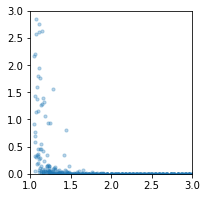

In [14]:
sensitivity = pd.read_csv('../data/sensitivity_1D.csv',index_col=0)
thresh=1e-6
Nreff = []
for item in sensitivity.index:
    Nreff.append((np.sqrt(np.abs(spectrum[item]))>thresh).sum())
    sensitivity.loc[item,'alpha'] = 500/Nreff[-1]
    
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.15)
ax.scatter(sensitivity['alpha'].values,np.array(sensitivity['ILvar'].values),s=10,alpha=0.3)
#plt.gca().set_xlabel(r'Number of Tregs/Rank of $p_{\alpha x}$')
#plt.gca().set_ylabel(r'Sensitivity $\langle (\partial g_i/\partial v_x)^2\rangle$')
ax.set_ylim((0,3))
ax.set_xlim((1,3))
pdf = bpdf.PdfPages('../figures/sense_1D_IL.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

In [9]:
np.min(Nreff)

97

In [10]:
np.max(Nreff)

484

# Pathogen response, allergies, persistent infection

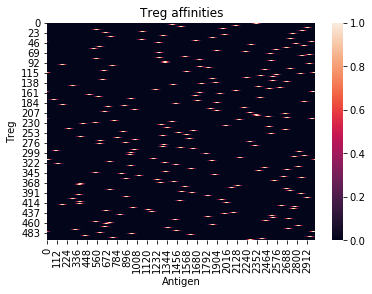

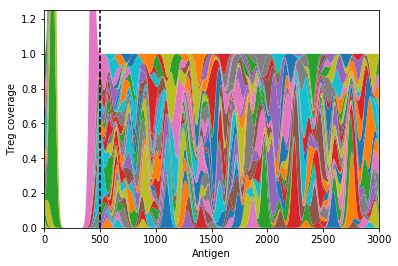

In [28]:
# Parameters
Num_path = 500
reg_thresh = 1e-2
cell_thresh = 1e-4
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 500
params['Num_tcell'] = 5000
params['Num_sites'] = 3000
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']

# Make affinities and plot
pix, palphax = MakeAffinities(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

#Make antigen concentrations
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
vx[:Num_path] = 0

#Positive selection:
palphax = palphax[palphax.dot(vx)>reg_thresh]
pix = pix[pix.dot(vx)>cell_thresh]

#Make overlaps and train
#palphax = palphax*(1+np.random.randn(params['Num_treg'],params['Num_sites'])*0.01)
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()


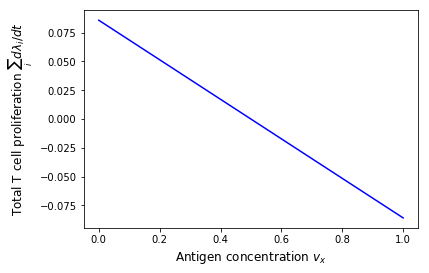

In [33]:
#Plot response for self antigen
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
vx_axis = np.linspace(0,1,5)
vx_new = np.array([vx.copy() for k in range(len(vx_axis))]).T
vx_new[xnormal,:] = vx_axis
fig,ax = plt.subplots()
ax.plot(vx_axis,dTcellxdt.dot(vx_new),color=colors[xnormal])
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
#ax.set_ylim((-1,1))
plt.show()

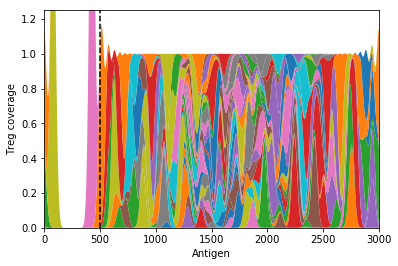

In [32]:
#Re-train with all antigens present
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()

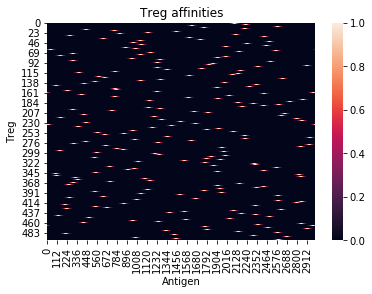

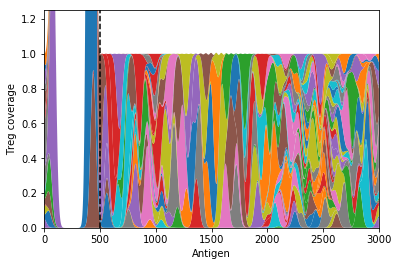

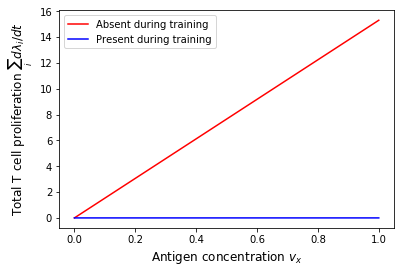

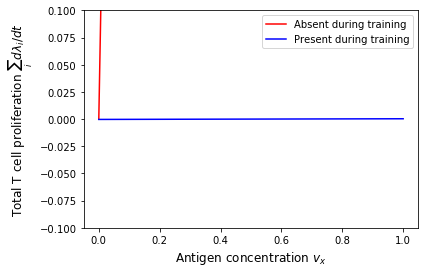

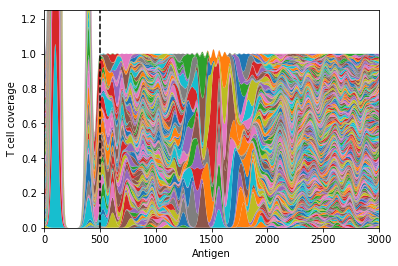

----------------Train to persistent infection--------------------


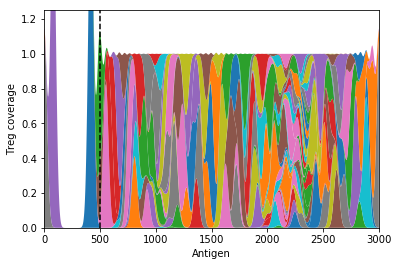

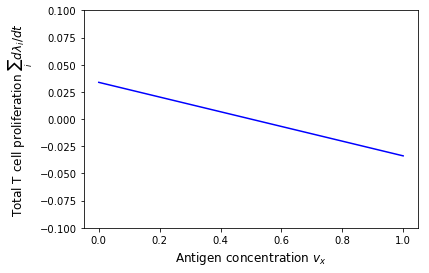

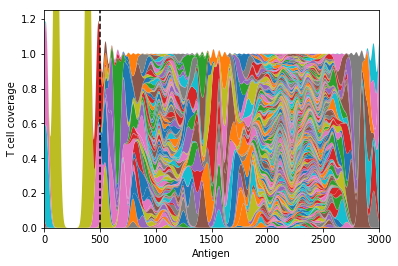

In [34]:
# Parameters
Num_path = 500
reg_thresh = 1e-2
cell_thresh = 1e-4
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 500
params['Num_tcell'] = 5000
params['Num_sites'] = 3000
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']

# Make affinities and plot
pix, palphax = MakeAffinities(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

#Make antigen concentrations
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
vx[:Num_path] = 0

#Positive selection:
palphax = palphax[palphax.dot(vx)>reg_thresh]
pix = pix[pix.dot(vx)>cell_thresh]

#Make overlaps and train
#palphax = palphax*(1+np.random.randn(params['Num_treg'],params['Num_sites'])*0.01)
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()

#Plot response for two antigens
colorlist = np.asarray(['b','r'])
colors = colorlist[np.asarray(vx==0,dtype=int)]
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
vx_axis = np.linspace(0,1,5)

xmin = np.argmax(dTcellxdt)
xnormal = 510
fig,ax = plt.subplots()
for x in [xmin,xnormal]:
    vx_new = np.array([vx.copy() for k in range(len(vx_axis))]).T
    vx_new[x,:] = vx_axis
    ax.plot(vx_axis,dTcellxdt.dot(vx_new),color=colors[x])
ax.plot([0],[0],color=colorlist[1],label='Absent during training')
ax.plot([0],[0],color=colorlist[0],label='Present during training')
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
#ax.set_ylim((-1,1))
plt.legend()
plt.show()
fig,ax = plt.subplots()
for x in [xmin,xnormal]:
    vx_new = np.array([vx.copy() for k in range(len(vx_axis))]).T
    vx_new[x,:] = vx_axis
    ax.plot(vx_axis,dTcellxdt.dot(vx_new),color=colors[x])
ax.plot([0],[0],color=colorlist[1],label='Absent during training')
ax.plot([0],[0],color=colorlist[0],label='Present during training')
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
ax.set_ylim((-.1,.1))
plt.legend()
plt.show()

#Plot T cell coverage
coverage = pix.T*Tcell
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('T cell coverage')
plt.show()

print('----------------Train to persistent infection--------------------')

#Re-train with all antigens present
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('Treg coverage')
plt.show()

#Plot response for self antigen
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
vx_axis = np.linspace(0,1,5)
vx_new = np.array([vx.copy() for k in range(len(vx_axis))]).T
vx_new[xnormal,:] = vx_axis
fig,ax = plt.subplots()
ax.plot(vx_axis,dTcellxdt.dot(vx_new),color=colors[xnormal])
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
ax.set_ylim((-.1,.1))
plt.show()

#Plot T cell coverage
coverage = pix.T*Tcell
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([Num_path,Num_path],[0,1.25],'k--')
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel('Antigen')
ax.set_ylabel('T cell coverage')
plt.show()

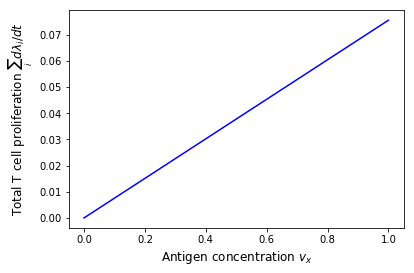

In [130]:
#Plot response for self antigen
dTcellxdt = ((pix*(1-palphax.T.dot(Treg))).T*Tcell).sum(axis=1)
xmin = np.argmax(dTcellxdt[Num_path:])+Num_path
vx_axis = np.linspace(0,1,5)
fig,ax = plt.subplots()
ax.plot(vx_axis,dTcellxdt[xmin]*vx_axis,color=colors[xnormal])
#ax.plot([0,1],[0,0],'k',lw=2)
ax.set_xlabel(r'Antigen concentration $v_x$',fontsize=12)
ax.set_ylabel(r'Total T cell proliferation $\sum_i d\lambda_i/dt$',fontsize=12)
#ax.set_ylim((-1,1))
plt.show()

# T cell population bottleneck

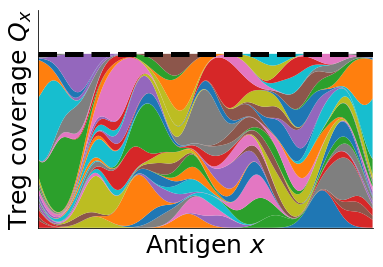

In [6]:
# Parameters
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 100
params['Num_tcell'] = 1000
params['Num_sites'] = 800
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/params['Num_treg']
pix, palphax = MakeAffinities(params)

#Make antigen concentrations
vx = np.ones(params['Num_sites'])

#Make overlaps and train
#palphax = palphax*(1+np.random.randn(params['Num_treg'],params['Num_sites'])*0.01)
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([0,len(vx)],[1,1],'k--',linewidth=5)
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel(r'Antigen $x$',fontsize=25)
ax.set_ylabel(r'Treg coverage $Q_x$',fontsize=25)
ax.set_xticks(())
ax.set_yticks(())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pdf = bpdf.PdfPages('../figures/tiling.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

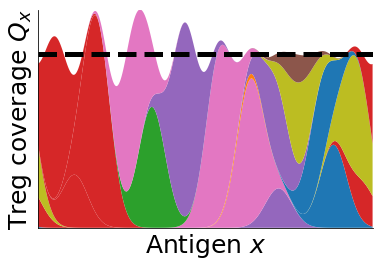

In [7]:
# Parameters
params = {}
params['sampling'] = '1D'
params['Num_treg'] = 50
params['Num_tcell'] = 1000
params['Num_sites'] = 800
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 4*params['Num_sites']/100
pix, palphax = MakeAffinities(params)

#Make antigen concentrations
vx = np.ones(params['Num_sites'])

#Make overlaps and train
#palphax = palphax*(1+np.random.randn(params['Num_treg'],params['Num_sites'])*0.01)
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Plot Treg coverage
coverage = palphax.T*Treg
fig,ax = plt.subplots()
ax.stackplot(np.arange(len(vx)),coverage.T)
ax.plot([0,len(vx)],[1,1],'k--',linewidth=5)
ax.set_ylim((0,1.25))
ax.set_xlim((0,len(vx)))
ax.set_xlabel(r'Antigen $x$',fontsize=25)
ax.set_ylabel(r'Treg coverage $Q_x$',fontsize=25)
ax.set_xticks(())
ax.set_yticks(())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pdf = bpdf.PdfPages('../figures/tiling_imp.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()